In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.optimize import leastsq
import matplotlib.cm as cm
import datetime
import json
import requests

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import seaborn as sns

# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(10, 6)})

In [2]:
# ref 
# https://github.com/100trillionUSD/bitcoin
# https://github.com/hamal03/btc-s2f/blob/master/cherrypick.py
# https://github.com/8go/bitcoin-stock-to-flow/blob/master/s2f.py

def get_data_from_coinmetrics():
    cmurl = "https://community-api.coinmetrics.io/v2/assets/btc/metricdata"
    cmapistr = '?metrics=PriceUSD%2CSplyCur%2CBlkCnt&start=2009-01-01'
    cmdata = requests.get(cmurl+cmapistr)
    jdata = json.loads(cmdata.text)
    return jdata

rawdata = get_data_from_coinmetrics()

In [3]:
def get_wiki():
    cmurl = "https://en.wikipedia.org/wiki/History_of_bitcoin"
    cmapistr = '?metrics=PriceUSD%2CSplyCur%2CBlkCnt&start=2009-01-01'
    cmdata = requests.get(cmurl+cmapistr)
    return cmdata.text
html = get_wiki()

In [4]:

columns = rawdata['metricData']['metrics']

# parase data
def myparse(row):
    date = datetime.datetime.strptime(row['time'],'%Y-%m-%dT%H:%M:%S.%fZ').date()
    mydict = {'date':date}
    for n,k in enumerate(columns):
        val = row['values'][n]
        val = float(val) if val is not None else np.nan
        mydict[k]=val
    return mydict

# compute stock-to-flow and forecasted price.

## conservative formula: 0.18*s2f^3.3
S2F_FORMULA = '0.18 * s2f ^ 3.3'
sf2_formula = lambda s2f: 0.18 * (s2f ** 3.3)

S2F_FORMULA_UPDATED = '1.262 * s2f ^ 2.681'
sf2_formula_updated = lambda s2f: 1.262 * (s2f ** 2.681)
def s2f_func(ii, df,ratio,newfit):
    x_df = df.iloc[ii]
    supply_before = x_df.SplyCur[0]
    supply_now = x_df.SplyCur[-1]
    stock_to_flow_ratio = supply_before / ((supply_now-supply_before)/period*365)
    if ratio:
        return stock_to_flow_ratio
    else:
        if not newfit:
            stock_to_flow_usd = sf2_formula(stock_to_flow_ratio)
        else:
            stock_to_flow_usd = sf2_formula_updated(stock_to_flow_ratio)
        return stock_to_flow_usd

# "batch inference"
df = pd.DataFrame([myparse(x) for x in rawdata['metricData']['series'] ])
df['ii'] = range(len(df))
df.index  = df.date

period = 365
res = df.ii.rolling(period).apply(lambda x: s2f_func(x, df, True, False))
df['s2f'] = res.values

res = df.ii.rolling(period).apply(lambda x: s2f_func(x, df, False, False))
df['s2f_usd'] = res.values

res = df.ii.rolling(period).apply(lambda x: s2f_func(x, df, False, True))
df['s2f_usd_updated'] = res.values

# https://gist.github.com/leto/a8818202ca4298cc3df5cb80b0aeaf82
nSubsidyHalvingInterval = 210000
df['halving']=df.BlkCnt.cumsum()//nSubsidyHalvingInterval
df['remainder']=df.BlkCnt.cumsum()%nSubsidyHalvingInterval
df['mnth_till_halving']= (48-df.remainder/nSubsidyHalvingInterval*12*4)
df['market_cap']= df.PriceUSD*df.SplyCur


In [5]:
tmpdf = df.copy(deep=True)

tmpdf = tmpdf.dropna()
y = tmpdf.PriceUSD
x = tmpdf.s2f

def residuals(p, y, x):
    A,B = p
    err = y-A*(x**B)
    return err

# 0.18*s2f^3.3
p0 = [0.18,3.3]
plsq = leastsq(residuals, p0, args=(y, x))
A,B = plsq[0]
NEW_FIT = f'{A:1.3f} * s2f ^ {B:1.3f}'
print(NEW_FIT)

1.262 * s2f ^ 2.681


Text(0, 0.5, 'btcusd')

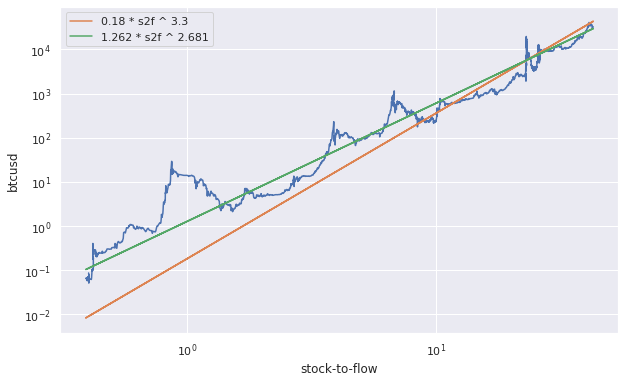

In [6]:
plt.plot(x,y)
plt.plot(x,0.18*x**3.3,label=S2F_FORMULA)
plt.plot(x,1.262*x**2.681,label=NEW_FIT)
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.xlabel('stock-to-flow')
plt.ylabel('btcusd')

In [7]:
np.min(tmpdf.date),np.max(tmpdf.date)

(datetime.date(2010, 7, 18), datetime.date(2021, 1, 24))

R:0.98


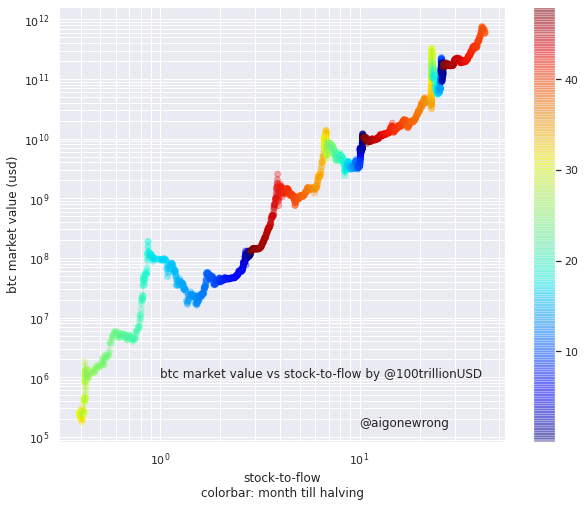

In [22]:
sns.set(rc={'figure.figsize':(10,8)})
fig, ax = plt.subplots()

ax.loglog(tmpdf.s2f,tmpdf.market_cap,alpha=0.1)

def get_annotation(date_str,description):
    s = datetime.datetime.strptime(date_str,'%Y-%m-%d').date()
    matched = tmpdf[tmpdf.date==s]
    return matched.s2f,matched.market_cap,description

dstr_list = []#[f'20{x}-01-01' for x in np.arange(11,20,1)]
for dstr in dstr_list:
    x,y,text=get_annotation(dstr,dstr)
    ax.annotate(text, xy=(x,y), xytext=(x,y+0.1),
                arrowprops=dict(
                    arrowstyle="->",
                    connectionstyle="angle3,angleA=0,angleB=-90",color='black'
                ))

x,y=1,10e5
ax.annotate("btc market value vs stock-to-flow by @100trillionUSD",xy=(x,y), xytext=(x,y))
x,y=10,1.5*10e4
ax.annotate("@aigonewrong",xy=(x,y), xytext=(x,y))

plt.scatter(tmpdf.s2f,
            tmpdf.market_cap,
            c=tmpdf.mnth_till_halving,
            cmap=cm.jet,
            alpha=0.3)

plt.yscale("log")
plt.xscale("log")
plt.colorbar()
plt.xlabel('stock-to-flow\ncolorbar: month till halving')
plt.ylabel('btc market value (usd)')
plt.grid(True, which="both", ls="-")

r=np.corrcoef(np.log(tmpdf.s2f),np.log(tmpdf.PriceUSD*tmpdf.SplyCur))
print(f'R:{r[0,1]:1.2f}')

In [9]:
print(df.shape)
print(df.head())

(4405, 12)
                  date  PriceUSD  SplyCur  BlkCnt  ii  s2f  s2f_usd  \
date                                                                  
2009-01-03  2009-01-03       NaN      0.0     0.0   0  NaN      NaN   
2009-01-04  2009-01-04       NaN      0.0     0.0   1  NaN      NaN   
2009-01-05  2009-01-05       NaN      0.0     0.0   2  NaN      NaN   
2009-01-06  2009-01-06       NaN      0.0     0.0   3  NaN      NaN   
2009-01-07  2009-01-07       NaN      0.0     0.0   4  NaN      NaN   

            s2f_usd_updated  halving  remainder  mnth_till_halving  market_cap  
date                                                                            
2009-01-03              NaN      0.0        0.0               48.0         NaN  
2009-01-04              NaN      0.0        0.0               48.0         NaN  
2009-01-05              NaN      0.0        0.0               48.0         NaN  
2009-01-06              NaN      0.0        0.0               48.0         NaN  
2009-

In [10]:
daily_block_count = df.BlkCnt.mean()

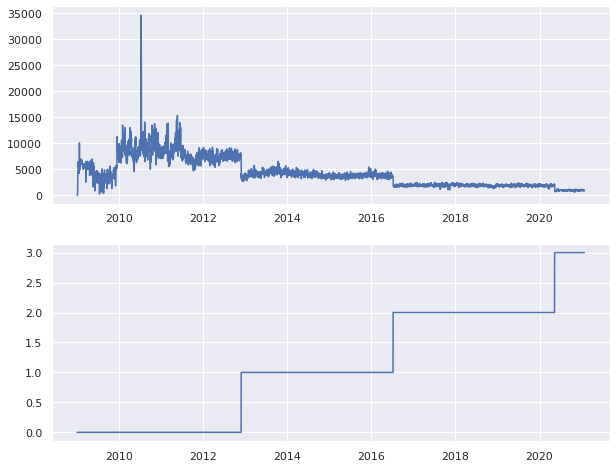

In [11]:
plt.title('visualizing btc mined every day and each halving')
plt.subplot(211)
plt.plot(df.SplyCur.diff(1))
plt.subplot(212)
plt.plot(df.BlkCnt.cumsum()//nSubsidyHalvingInterval)

In [12]:
# derive BlkCnt, SplyCur
numdays = 365*10 # predict next x days
base = datetime.datetime.today()-datetime.timedelta(days=1)
date_list = [(base+ datetime.timedelta(days=x)).date() for x in range(numdays)]
dff = pd.DataFrame()
dff['date']=date_list
dff.index = dff.date
median_block_count = df.BlkCnt.median()
print(median_block_count)
dfm = pd.concat([df,dff],axis=0)
dfm['ii'] = range(len(dfm))
dfm.BlkCnt = dfm.BlkCnt.fillna(value=median_block_count)
dfm['halving']=dfm.BlkCnt.cumsum()//nSubsidyHalvingInterval
dfm['remainder']=dfm.BlkCnt.cumsum()%nSubsidyHalvingInterval
dfm['mnth_till_halving']= (48-dfm.remainder/nSubsidyHalvingInterval*12*4)
dfm['production']=dfm.SplyCur.diff(1)

152.0


Text(0.5, 1.0, 'mnth_till_halving')

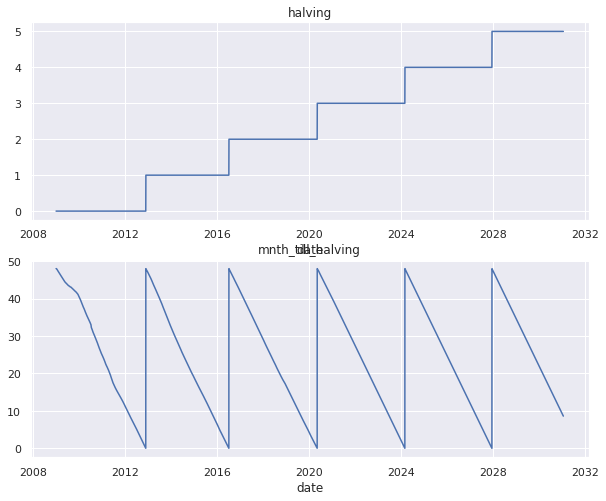

In [13]:
# sanity check
plt.subplot(211)
dfm.halving.plot()
plt.title('halving')
plt.subplot(212)
dfm.mnth_till_halving.plot()
plt.title('mnth_till_halving')

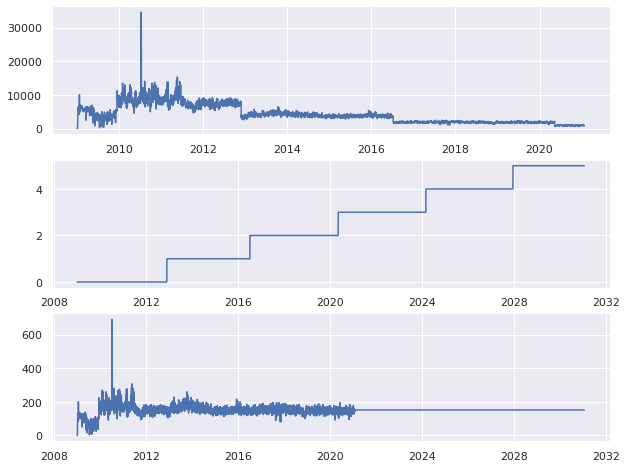

In [14]:
plt.title('visualizing btc mined every day and each halving')
plt.subplot(311)
plt.plot(dfm.SplyCur.diff(1))
plt.subplot(312)
plt.plot(dfm.BlkCnt.cumsum()//nSubsidyHalvingInterval)
plt.subplot(313)
plt.plot(dfm.BlkCnt)

In [15]:
# naive ugly esimate with 
for n,row in dfm.iterrows():
    if np.isnan(row.SplyCur):
        yesterday = n-datetime.timedelta(days=1)
        yesterday_row = dfm[dfm.date==yesterday]
        estimated_production = np.nanmedian(dfm[dfm.halving==row.halving].production)
        if np.isnan(estimated_production):
            estimated_production = 0.5*np.nanmedian(dfm[dfm.halving==row.halving-1].production)
        dfm.at[n,'production'] = estimated_production
        dfm.at[n,'SplyCur'] = yesterday_row.SplyCur[0]+estimated_production

/usr/local/lib/python3.6/dist-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/usr/local/lib/python3.6/dist-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


In [16]:
res = dfm.ii.rolling(period).apply(lambda x: s2f_func(x, dfm, True,False))
dfm['s2f'] = res.values
res = dfm.ii.rolling(period).apply(lambda x: s2f_func(x, dfm, False,False))
dfm['s2f_usd'] = res.values
res = dfm.ii.rolling(period).apply(lambda x: s2f_func(x, dfm, False,True))
dfm['s2f_usd_update'] = res.values

In [17]:
dfm

,date,PriceUSD,SplyCur,BlkCnt,ii,s2f,s2f_usd,s2f_usd_updated,halving,remainder,mnth_till_halving,market_cap,production,s2f_usd_update
date,,,,,,,,,,,,,,
2009-01-03,2009-01-03,NaN,0.000000e+00,0.0,0,NaN,NaN,NaN,0.0,0.0,48.000000,NaN,NaN,NaN
2009-01-04,2009-01-04,NaN,0.000000e+00,0.0,1,NaN,NaN,NaN,0.0,0.0,48.000000,NaN,0.000000,NaN
2009-01-05,2009-01-05,NaN,0.000000e+00,0.0,2,NaN,NaN,NaN,0.0,0.0,48.000000,NaN,0.000000,NaN
2009-01-06,2009-01-06,NaN,0.000000e+00,0.0,3,NaN,NaN,NaN,0.0,0.0,48.000000,NaN,0.000000,NaN
2009-01-07,2009-01-07,NaN,0.000000e+00,0.0,4,NaN,NaN,NaN,0.0,0.0,48.000000,NaN,0.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2031-01-17,2031-01-17,NaN,2.054479e+07,152.0,8050,244.732677,1.373903e+07,NaN,5.0,171724.0,8.748800,NaN,229.687493,3.199945e+06
2031-01-18,2031-01-18,NaN,2.054502e+07,152.0,8051,244.735424,1.373954e+07,NaN,5.0,171876.0,8.714057,NaN,229.687493,3.200041e+06
2031-01-19,2031-01-19,NaN,2.054525e+07,152.0,8052,244.738171,1.374004e+07,NaN,5.0,172028.0,8.679314,NaN,229.687493,3.200138e+06


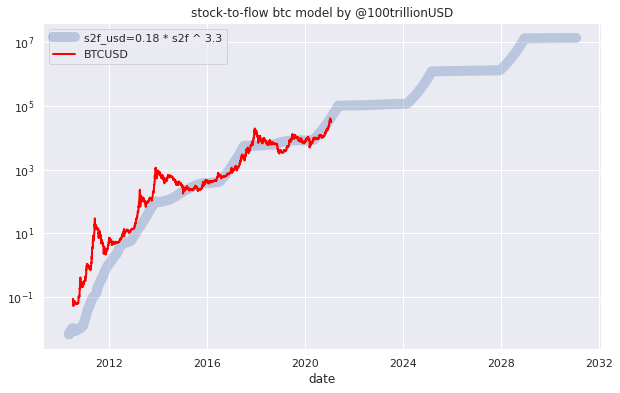

In [18]:
sns.set(rc={'figure.figsize':(10, 6)})
dfm.s2f_usd[500:].plot(label=f's2f_usd={S2F_FORMULA}',linewidth=10,alpha=0.3)
#dfm.s2f_usd_update[500:].plot(label=f's2f_usd={S2F_FORMULA_UPDATED}',linewidth=10,alpha=0.3)
dfm.PriceUSD[500:].plot(label='BTCUSD',linewidth=2,color='red')
plt.yscale("log")
plt.title('stock-to-flow btc model by @100trillionUSD')
plt.grid(True)
plt.legend()

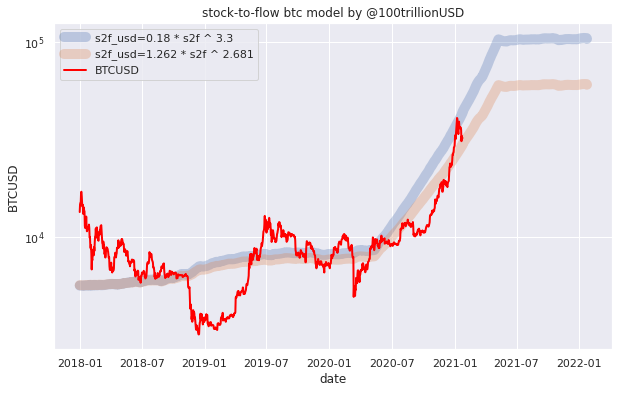

In [19]:
sns.set(rc={'figure.figsize':(10, 6)})
s=365*9
e=-365*9
dfm.s2f_usd[s:e].plot(label=f's2f_usd={S2F_FORMULA}',linewidth=10,alpha=0.3)
dfm.s2f_usd_update[s:e].plot(label=f's2f_usd={S2F_FORMULA_UPDATED}',linewidth=10,alpha=0.3)
dfm.PriceUSD[s:e].plot(label='BTCUSD',linewidth=2,color='red')
plt.yscale("log")
plt.title('stock-to-flow btc model by @100trillionUSD')
plt.grid(True)
plt.xlabel('date')
plt.ylabel('BTCUSD')
plt.legend()

In [20]:
d_list = [-256*x for x in np.arange(1,30,5)]
d_list=d_list[::-1]
d_list.append(-1)
for d in d_list:
    print('date: {}, estimate: {}'.format(dfm.date[d],dfm.s2f_usd[d]))

date: 2012-11-02, estimate: 5.36169166645767
date: 2016-05-05, estimate: 393.80395394840315
date: 2019-11-06, estimate: 8395.020540528421
date: 2023-05-08, estimate: 111707.39472119378
date: 2026-11-08, estimate: 1279777.1101917974
date: 2030-05-11, estimate: 13611693.487609692
date: 2031-01-21, estimate: 13741062.850401169
